# Python Libraries #

In [ ]:
pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.5 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=9aa95987b5118ef4238e45c342a8a8a4160181e9e710b082a12e07a94241de31
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, make_union
from tpot.export_utils import set_param_recursive
from sklearn.ensemble import RandomForestClassifier



# Data Preparation

In [ ]:
data = pd.read_csv("/content/employee_promotion.csv")


#### Dropping unnecessary features

In [ ]:
data=data.drop(columns=['employee_id'])

## Pre Traitement

####Encoding categorical features

In [ ]:
pro = preprocessing.LabelEncoder()
encpro = pro.fit_transform(data['education'].astype(str))
data['education'] = encpro

pro = preprocessing.LabelEncoder()
encpro = pro.fit_transform(data['region'])
data['region'] = encpro


In [ ]:
data = pd.get_dummies(data, columns=['department', 'gender', 'recruitment_channel'], dtype=int)


Coorelation of feature

#### NULL

In [ ]:
data['previous_year_rating'].fillna(value=0,inplace=True)

Education and Previous_Year_rating null values

In [ ]:
data['education'] = data['education'].fillna(data['education'].mode()[0])
data['avg_training_score'] = data['avg_training_score'].fillna(data['avg_training_score'].mode()[0])

In [ ]:
data.isnull().sum()

,0
department,0
region,0
education,0
gender,0
recruitment_channel,0
no_of_trainings,0
age,0
previous_year_rating,0
length_of_service,0
awards_won,0


#### Label and features


In [ ]:
X=data.drop(columns=['is_promoted'])
y=data['is_promoted']

# Model Building

## INTIAL DATA

#### Data Split for Validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

#### TRAIN

In [ ]:
from xgboost import XGBClassifier


# Average CV score on the training set was: 0.9407011599113776
exported_pipeline = XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=17, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=1,
              num_parallel_tree=None, random_state=42, ...)

#### Evaluation of model

In [ ]:
results = exported_pipeline.predict(X_test)


In [ ]:
print(classification_report(y_test, results))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     15035
           1       0.92      0.34      0.50      1408

    accuracy                           0.94     16443
   macro avg       0.93      0.67      0.73     16443
weighted avg       0.94      0.94      0.93     16443



## Upsampled data

In [ ]:
from imblearn.over_sampling import SMOTE
import seaborn as sns


#### Data Split for Validation

In [ ]:
smt = SMOTE()
X_up, y_up = smt.fit_resample(X, y)

<Axes: xlabel='is_promoted', ylabel='count'>

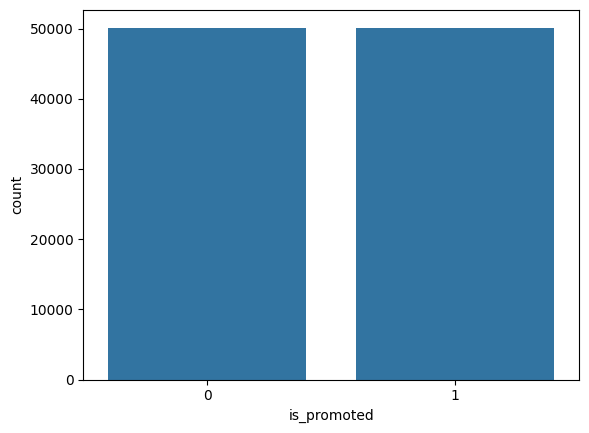

In [ ]:
sns.countplot(data= data, x = y_up)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.3, random_state=2)

#### Random Forest Model

In [ ]:
# Average CV score on the training set was: 0.9463217270813965
exported_pipeline1 = RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.4, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline1, 'random_state'):
    setattr(exported_pipeline1, 'random_state', 42)

exported_pipeline1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=0.4, min_samples_split=4,
                       random_state=42)

#### Evaluation of model

In [ ]:
results1 = exported_pipeline1.predict(X_test)


In [ ]:
print(classification_report(y_test, results1))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95     15105
           1       0.97      0.94      0.95     14979

    accuracy                           0.95     30084
   macro avg       0.95      0.95      0.95     30084
weighted avg       0.95      0.95      0.95     30084



## Upsampled data Smote + Tomek

In [ ]:
from imblearn.combine import SMOTETomek
import seaborn as sns


#### Data Split for Validation

In [ ]:
smt = SMOTETomek()
X_up, y_up = smt.fit_resample(X, y)

<Axes: xlabel='is_promoted', ylabel='count'>

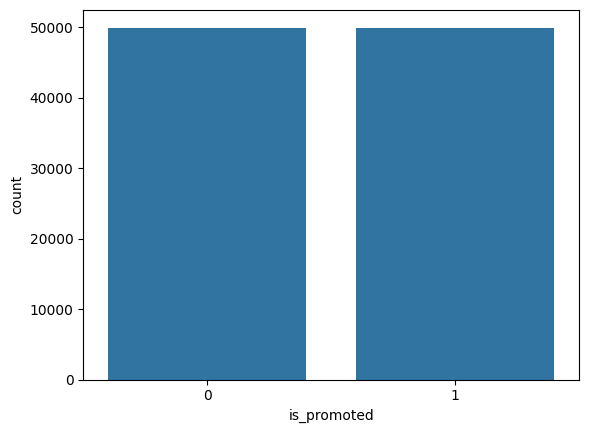

In [ ]:
sns.countplot(data= data, x = y_up)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.3, random_state=2)

#### TRAIN

In [ ]:
# Average CV score on the training set was: 0.9468762157044133
exported_pipeline2 = ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.9000000000000001, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline2, 'random_state'):
    setattr(exported_pipeline2, 'random_state', 42)
exported_pipeline2.fit(X_train, y_train)


ExtraTreesClassifier(max_features=0.9000000000000001, min_samples_split=3,
                     random_state=42)

#### Evaluation of model

In [ ]:
results2 = exported_pipeline2.predict(X_test)


In [ ]:
print(classification_report(y_test, results2))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14946
           1       0.96      0.94      0.95     15038

    accuracy                           0.95     29984
   macro avg       0.95      0.95      0.95     29984
weighted avg       0.95      0.95      0.95     29984



## Upsampled data Smote + ENN

In [ ]:
from imblearn.combine import SMOTEENN
import seaborn as sns


#### Data Split for Validation

In [ ]:
smt = SMOTEENN()
X_up, y_up = smt.fit_resample(X, y)

<Axes: xlabel='is_promoted', ylabel='count'>

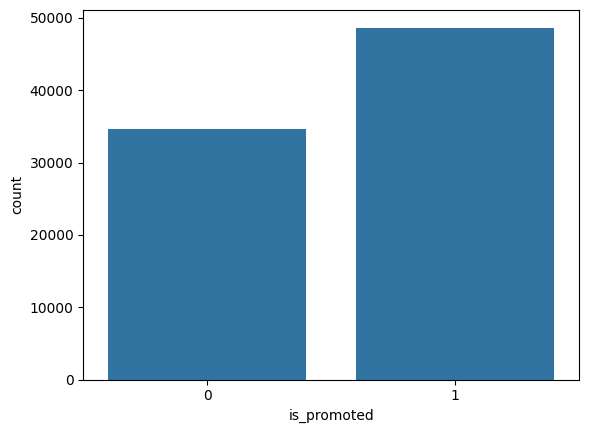

In [ ]:
sns.countplot(data= data, x = y_up)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.3, random_state=2)

#### KNN Model

In [ ]:
# Average CV score on the training set was: 0.9651896739563182
exported_pipeline3 = make_pipeline(
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=4, n_estimators=100)),
    KNeighborsClassifier(n_neighbors=3, p=1, weights="distance")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline3.steps, 'random_state', 42)



In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(exported_pipeline3, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())
print("Standard deviation of accuracy:", cv_scores.std())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not 

Cross-validation accuracy scores: [0.96688685 0.96388436 0.96628635 0.9695462  0.96517114]
Mean accuracy: 0.9663549798404392
Standard deviation of accuracy: 0.0018961476713248435


In [ ]:
exported_pipeline3.fit(X_train, y_train)

#### Evaluation of model

In [ ]:
results3 = exported_pipeline3.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


In [ ]:
print(classification_report(y_test, results3))


              precision    recall  f1-score   support

           0       0.99      0.94      0.97     10479
           1       0.96      1.00      0.98     14519

    accuracy                           0.97     24998
   macro avg       0.98      0.97      0.97     24998
weighted avg       0.97      0.97      0.97     24998



## Downsample data

#### Data Split for Validation

In [ ]:
data["is_promoted"].value_counts()

,count
is_promoted,
0,50140
1,4668


In [ ]:
promoted=data[data["is_promoted"]==1] #getting the promoted employees
not_promoted=data[data["is_promoted"]==0] #getting not promoted employees
not_promoted=not_promoted.sample(4668) #getting only 4668 fromnot employees to down sample the data equal
downsample=pd.concat([promoted, not_promoted]) #now combining both
downsample

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
11,7,31,0,0,2,1,35,5.0,3,0,50.0,1
39,7,20,0,1,2,1,33,5.0,6,0,51.0,1
60,7,28,2,1,0,1,50,4.0,17,0,47.0,1
66,1,14,0,1,0,1,27,0.0,1,1,58.0,1
67,7,14,0,1,2,1,27,0.0,1,0,50.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8536,4,18,0,1,2,1,29,1.0,4,0,58.0,0
47310,1,11,0,1,2,1,35,5.0,9,0,50.0,0
29005,4,11,0,0,2,1,33,5.0,7,0,60.0,0
16499,8,7,2,0,0,1,55,2.0,4,0,80.0,0


<Axes: xlabel='is_promoted', ylabel='count'>

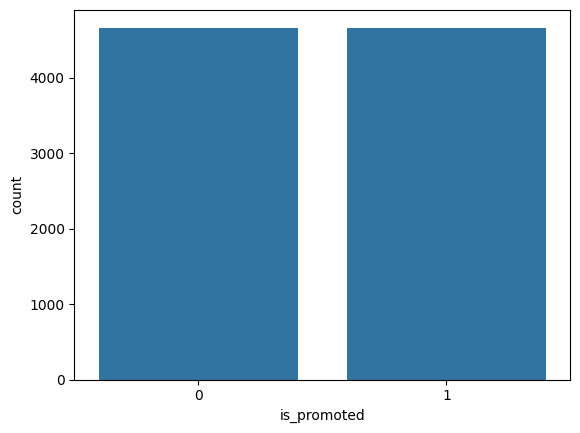

In [ ]:
sns.countplot(data= data, x = downsample['is_promoted'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(downsample.drop(columns=['is_promoted']), downsample['is_promoted'], test_size=0.3, random_state=2)

#### XGB Model

In [ ]:
# Average CV score on the training set was: 0.7267023718439174
exported_pipeline4 = XGBClassifier(learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline4, 'random_state'):
    setattr(exported_pipeline4, 'random_state', 42)

exported_pipeline4.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=1,
              num_parallel_tree=None, random_state=42, ...)

#### Evaluation of model

In [ ]:
results4 = exported_pipeline4.predict(X_test)


In [ ]:
print(classification_report(y_test, results4))


              precision    recall  f1-score   support

           0       0.67      0.83      0.74      1373
           1       0.79      0.61      0.69      1428

    accuracy                           0.72      2801
   macro avg       0.73      0.72      0.71      2801
weighted avg       0.73      0.72      0.71      2801

